In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Path to the video
VIDEO_PATH = Path('datasets/adl-09-cam0.mp4')

# Index of the sample frame
I_SAMPLE_FRAME = 30

# Relative crop region (x, y, w, h)
CROP_REGION_RELATIVE = (0.5, 0, 0.5, 1)

# Display image using matplotlib
def imshow(img, cvt=cv.COLOR_BGR2RGB):
    plt.imshow(cv.cvtColor(img, cvt))

In [3]:
# Open the video
cap = cv.VideoCapture(str(VIDEO_PATH))

# Get the original width and height of the video frames
orig_w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH)) # original height
orig_h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT)) # original width

# Calculate the absolute crop region
crop_x, crop_y, crop_w, crop_h = [
    int(v)
    for v in (
        orig_w * CROP_REGION_RELATIVE[0], # Calculate the x-coordinate of the crop region relative to the frame width
        orig_h * CROP_REGION_RELATIVE[1], # Calculate the y-coordinate of the crop region relative to the frame height
        orig_w * CROP_REGION_RELATIVE[2], # Calculate the width of the crop region relative to the frame width
        orig_h * CROP_REGION_RELATIVE[3], # Calculate the height of the crop region relative to the frame height
    )
]

# Crop the frame using the calculated coordinates
def pre_crop(frame):
    return frame[crop_y:crop_y+crop_h, crop_x:crop_x+crop_w]

In [4]:
# initialize a list to store frames
frames: list[np.ndarray] = []

# Process the video frame by frame
while True:
    ret, frame = cap.read() # Read a frame from the video
    if not ret:
        break # Exit the loop if no frame is read (end of the video)

    frame = pre_crop(frame) # Crop the frame using the pre_crop function
    frames.append(frame) # Append the cropped frame to the list

    if cv.waitKey(1) & 0xFF == ord("q"):
        break # Exit the loop if the "q" key is pressed

# Released the video capture object and close all OpenCV windows
cap.release()
cv.destroyAllWindows()

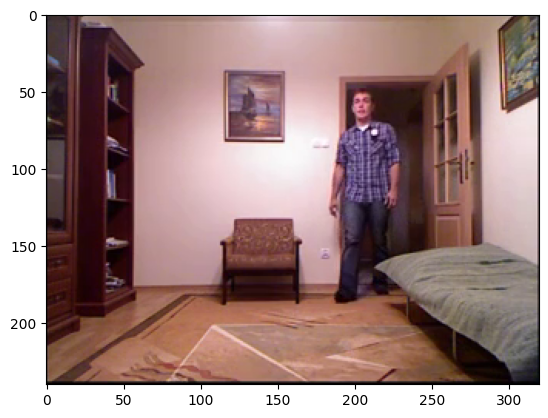

In [5]:
# Display each frame stored in the frame list
for frame in frames:
    cv.imshow("Frame", frame) # Show the current frame in a window titled "Frame"
    if cv.waitKey(1) & 0xFF == ord("q"):
        break # Exit the loop if the "q" key is pressed

# Released the video capture object and close all OpenCV windows
cap.release()
cv.destroyAllWindows()

# Display a specific frame using the imshow function
imshow(frames[I_SAMPLE_FRAME])

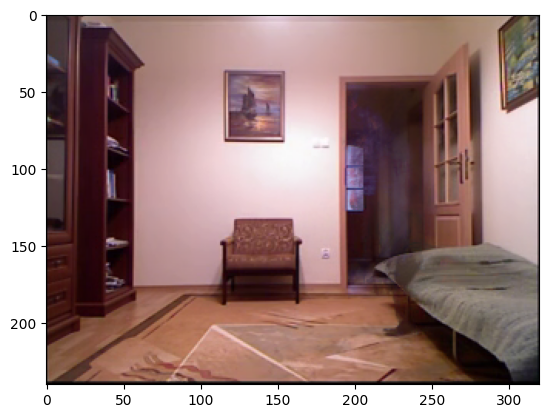

In [6]:
# Background estimation

bg = np.median(frames, axis=0).astype(np.uint8) # Compute the median of the frames to estimate the background
bg_gray = cv.cvtColor(bg, cv.COLOR_BGR2GRAY) # Convert the background to grayscale
plt.imshow(bg[..., ::-1]) # Convert BGR to RGB for display in matplotlib

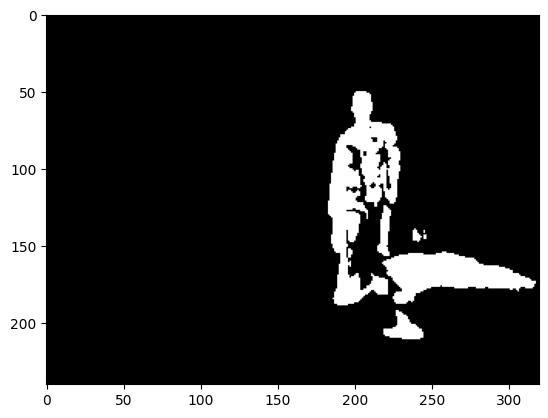

In [7]:
def mask_from_diff_3d(a, b, threshold=30):
    diff = cv.absdiff(a, b) # Compute the absolute difference between the two input images
    # mask = np.where(diff > threshold, 255, 0).astype(np.uint8)
    mask = np.where(np.linalg.norm(diff, axis=2) > threshold, 255, 0).astype(np.uint8) # Calculate mask based on threshold and 3D distances
    return mask
            

frames_mask = []

bg_blur = cv.GaussianBlur(bg, (5, 5), 0) # Apply Gaussian blur to the background image

# Substract frame from background
for frame in frames:
    frame = cv.GaussianBlur(frame, (5, 5), 0) # Apply Gaussian blur to the current frame
    mask = mask_from_diff_3d(frame, bg_blur, threshold=40) # Generate mask using the defined function

    frames_mask.append(mask)
    cv.imshow("Frame", mask)

    # Contours
    contours, _ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) # Find contours in the mask
    for contour in contours:
        if cv.contourArea(contour) < 100: # Filter out small contours
            continue
        x, y, w, h = cv.boundingRect(contour) # Get bounding box coordinates
        cv.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2) # Draw bounding box around the contour
    cv.imshow("Contours", frame) # Display frame with contours

    if cv.waitKey(1) & 0xFF == ord("q"):
        break # Exit the loop if the "q" key is pressed

# Released the video capture object and close all OpenCV windows
cap.release()
cv.destroyAllWindows()

# Display the mask of the sample frame
imshow(frames_mask[I_SAMPLE_FRAME])

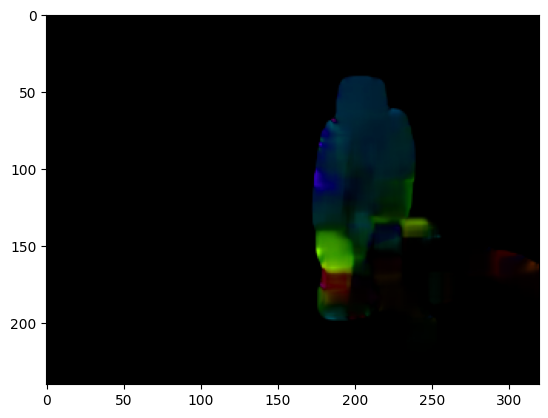

In [8]:
frames_flow_bgr = []

# Dense optical flow
i = 0
for frame in frames:
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY) # Convert frame to grayscale
    frame_gray_masked = cv.bitwise_and(frame_gray, frame_gray, mask=frames_mask[i]) # Apply mask to the grayscale frame
    if "prev" in locals(): # Check if "prev" variable exists
        # Calculate optical flow between previous and current frames
        flow = cv.calcOpticalFlowFarneback(prev, frame_gray_masked, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        mag, ang = cv.cartToPolar(flow[..., 0], flow[..., 1]) # Convert cartesian to polar coordinates
        hsv = np.zeros_like(frame)
        hsv[..., 1] = 255 # Set saturation value to maximum
        hsv[..., 0] = ang * 180 / np.pi / 2 # Convert angle to degrees
        hsv[..., 2] = cv.normalize(mag, None, 0, 255, cv.NORM_MINMAX) # Normalize magnitude
        bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR) # Convert HSV to BGR color

        frames_flow_bgr.append(bgr) # Append the resulting frame to the list
        cv.imshow("Frame", bgr) # Display the resulting frame
        if cv.waitKey(1) & 0xFF == ord("q"):
            break # Exit the loop if the "q" key is pressed
    prev = frame_gray_masked # Update the previous frame
    i += 1 # Increment the frame index

# Released the video capture object and close all OpenCV windows
cap.release()
cv.destroyAllWindows()

# Display the flow of the sample frame
imshow(frames_flow_bgr[I_SAMPLE_FRAME])

In [9]:
# Select a ROI in the sample frame
bbox_init = cv.selectROI(frames[I_SAMPLE_FRAME], False)

# Close OpenCV windows after selecting the ROI
cv.destroyAllWindows()

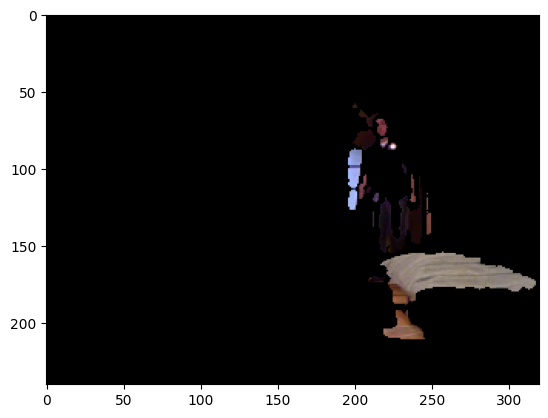

In [10]:
centroid_path = [] # List to store centroid positions
is_falls = [] # List to store fall detection results
accelerations = [] # List to store calculated accelerations
frames_overlayed = [] # List to store frames with overlays

def is_falling(accelerations, threshold=5):
    # Determine if a person is falling based on acceleration
    if len(accelerations) < 3: # Check if there are enough acceleration values
        return False
    return np.linalg.norm(accelerations[-1]) > threshold # Check if the magnitude of the latest acceleration is greater than the threshold

frame = frames[0].copy() # Copy the first frame
frame = cv.bitwise_and(frame, frame, mask=frames_mask[0]) # Apply the mask to the frame
imshow(frame) # Display the masked frame
tracker = cv.TrackerCSRT_create() # Create CSRT tracker
tracker.init(frames_mask[0], bbox_init) # Initialized the tracker with the initial bounding box

for i in range(1, len(frames)):
    frame_mask = frames_mask[i] # Get the mask for the current frame
    frame = frames[i] # Get the current frame
    frame = frame.copy() # Create a copy of the frame
    frame = cv.bitwise_and(frame, frame, mask=frame_mask) # Apply the mask to the frame
    cv.imshow("Mask", frame_mask) # Display the mask
    ok, bbox = tracker.update(frame) # Update the tracker with current frame

    if ok:
        x, y, w, h = [int(v) for v in bbox] # Extract bounding box coordinates
        cv.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2) # Draw bounding box
        cv.circle(frame, (x+w//2, y+h//2), 3, (0, 255, 0), -1) # Draw centroid
        centroid_path.append((x+w//2, y+h//2)) # Add centroid to the path

        if len(centroid_path) >= 2: # If there are at least two centroid positions
            velocity = np.array(centroid_path[-1]) - np.array(centroid_path[-2]) # Calculate velocity
            cv.putText(frame, f"v: {velocity}", (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2) # Display velocity

        if len(centroid_path) >= 3: # If there are at least three centroid positions
            acceleration = velocity - (np.array(centroid_path[-2]) - np.array(centroid_path[-3])) # Calculate acceleration
            cv.putText(frame, f"a: {acceleration}", (10, 40), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2) # Display acceleration
            accelerations.append(acceleration) # Add acceleration to the list
        
        is_fall = False
        if is_falling(accelerations, 5):
            is_fall = True
            cv.putText(frame, "FALLING!", (10, 60), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        is_falls.append(is_fall) # Append fall detection result to the list

    frames_overlayed.append(frame) # Append the current frame with overlays to the list
    cv.imshow("Frame", frame) # Display the current frame with overlays
    if cv.waitKey(1) & 0xFF == ord("q"):
        break # Exit the loop if the "q" key is pressed

# Released the video capture object and close all OpenCV windows
cap.release()
cv.destroyAllWindows()

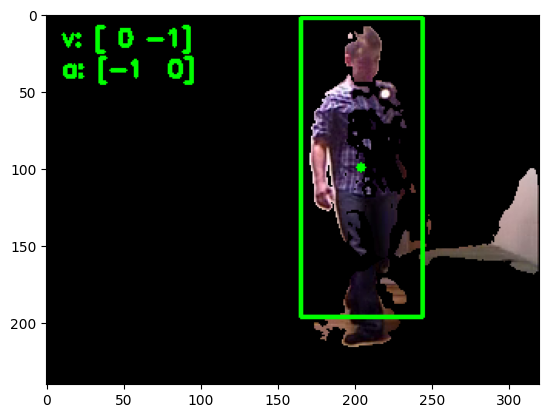

In [14]:
# Display the frame with overlays
imshow(frames_overlayed[73])

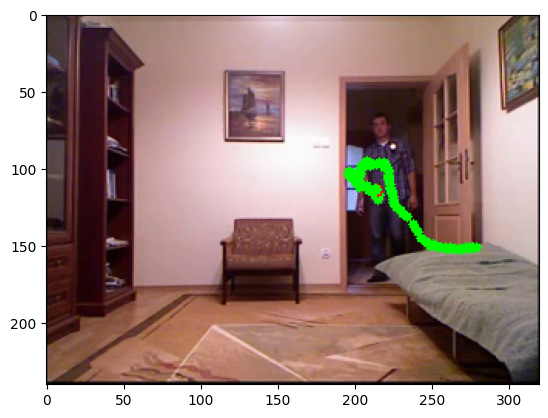

In [12]:
# Show centroid path on top of the first frame
frame = frames[0].copy() # Copy the first frame
for i in range(0, len(centroid_path)): # Loop through the centroid path
    x, y = centroid_path[i] # Get the coordinates of the centroid
    color = (0, 0, 255) if is_falls[i] else (0, 255, 0) # Set the color based on whether a fall was detected
    cv.circle(frame, (x, y), 3, color, -1) # Draw a circle at the centroid posistion with the appropriate color
imshow(frame) # Display the first frame with the centroid path overlaid

In [13]:
# Released the video capture object and close all OpenCV windows
cap.release()
cv.destroyAllWindows()